In [2]:


import email
import email.policy
import os

import numpy as np

os.listdir('./dataset')

['ham', 'spam']

In [3]:
hams = os.listdir('./dataset/ham')
spams = os.listdir('./dataset/spam')

In [4]:
def l_email(email_name):
    with open(email_name, 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)


def l_spam(filename):
    return l_email(os.path.join('./dataset/spam', filename))


def l_ham(filename):
    return l_email(os.path.join('./dataset/ham', filename))

In [5]:
# Subject - Probably can be used by itself
# From - May contain usefully information
# Content-Type - Ham emails less likely to have html type

In [6]:
import pandas as pd

spams = list(map(lambda x: l_spam(x), spams))
hams = list(map(lambda x: l_ham(x), hams))

In [7]:
def as_valid(emails):
    valid = []

    for index, email in enumerate(emails):
        try:
            email.get_body().get_content()

            valid.append(email)
        except LookupError:
            continue
        except AttributeError:
            continue

    return valid


def parse_subjects(emails):
    return [email.get('Subject') for email in emails]


def parse_types(emails):
    def get_type(email):
        if email.get('Content-Type') is None:
            return None

        return email.get('Content-Type').split(';')[0].lower()

    return [get_type(email) for email in emails]


def parse_content(emails):
    return [email.get_body().get_content() for email in emails]


def to_df(emails):
    valid = as_valid(emails)

    return pd.DataFrame(
        {'subject': parse_subjects(valid), 'type': parse_types(valid), 'content': parse_content(valid)})

In [8]:
spams_df = to_df(spams)
hams_df = to_df(hams)

<AxesSubplot:>

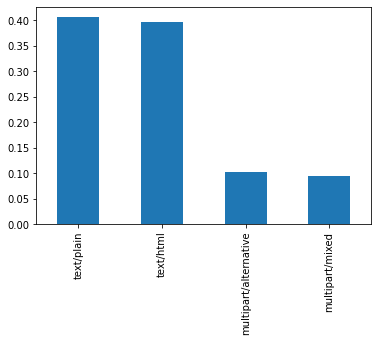

In [9]:
spams_df['type'].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

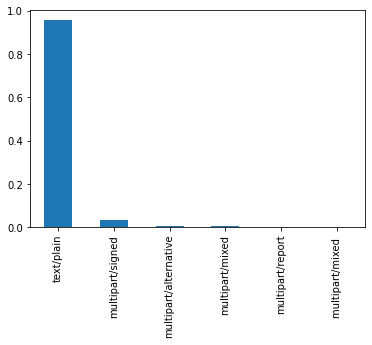

In [10]:
# html type is a good metric to find out spam emails
hams_df['type'].value_counts(normalize=True).plot(kind='bar')

In [11]:
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khaimov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Khaimov\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [44]:
import string
import re
from bs4 import BeautifulSoup

ps = nltk.stem.PorterStemmer()


def sentence_to_words(subject):
    no_links = re.sub(r'https?://\S+', 'link', subject)
    no_punctuation = no_links.translate(str.maketrans('', '', string.punctuation))
    no_digits = re.sub(r'\d+', 'digit', no_punctuation)

    words = nltk.word_tokenize(no_digits)
    stemmed = [ps.stem(word) for word in words]

    return list(map(lambda x: x[0], filter(lambda x: x[1] == 'NN' or x[1] == 'VB', nltk.pos_tag(stemmed))))


def email_to_words(email):
    return set(sentence_to_words(email['subject']) + sentence_to_words(BeautifulSoup(email['content']).get_text()))


def emails_to_words(emails):
    words = emails[emails['type'].notna()]

    return pd.Series(words.apply(lambda x: list(email_to_words(x)), axis=1).sum())



In [20]:
emails_to_words(spams_df).value_counts(normalize=1)

c:\users\khaimov\pycharmprojects\ml-learn\venv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


digit                             0.010022
be                                0.009407
thi                               0.008116
email                             0.007839
list                              0.006702
                                    ...   
booksblackrealitypublishingcom    0.000031
burden                            0.000031
commentari                        0.000031
poverti                           0.000031
efficaci                          0.000031
Length: 5814, dtype: float64

In [21]:
emails_to_words(hams_df).value_counts(normalize=1)

c:\users\khaimov\pycharmprojects\ml-learn\venv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\users\khaimov\pycharmprojects\ml-learn\venv\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


link           0.014289
digit          0.011958
re             0.009403
i              0.009301
be             0.008615
                 ...   
touchton       0.000009
keypad         0.000009
inputmethod    0.000009
brotherton     0.000009
goahead        0.000009
Length: 14670, dtype: float64

In [138]:
keywords = [
    'click',
    'email',
    'inform',
    'receiv',
    'money',
    'market',
    'contact',
    'list',
    'link',
    'offer',
    'price',
    'order',
    'servic',
    'pay',
    'rate',
    'guarante',
    'dollar',
    'opportun',
    'free'
]

In [248]:
def email_words_to_features(email):
    words = email_to_words(email)

    return pd.Series(map(lambda keyword: int(keyword in words), keywords), index=keywords)


def email_type_to_feature(email):
    return pd.Series([int(email['type'] == 'text/html')], index=['is_html'])


def email_to_instance(email):
    return pd.concat([
        email_type_to_feature(email),
        email_words_to_features(email),
        pd.Series([email['spam']], index=['spam'])
    ])


spams_df['spam'] = 1
hams_df['spam'] = 0
emails = spams_df.append(hams_df)

X = emails.fillna({'subject': '', 'type': 'text/plain'}).apply(email_to_instance, axis=1)

c:\users\khaimov\pycharmprojects\ml-learn\venv\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
c:\users\khaimov\pycharmprojects\ml-learn\venv\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [275]:
import sklearn.model_selection as ms

X_train, X_test, y_train, y_test = ms.train_test_split(X[X.columns[0:-1]].to_numpy(), X[X.columns[-1:]].to_numpy(),
                                                       random_state=42,
                                                       test_size=0.2)

c:\users\khaimov\pycharmprojects\ml-learn\venv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9506578947368421

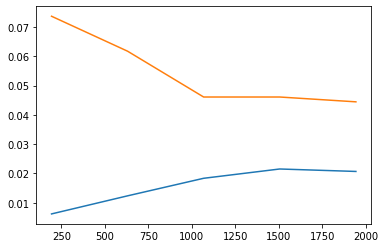

In [287]:
import sklearn.linear_model as lm
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('poly', pp.PolynomialFeatures(degree=4)),
    ('clf', lm.LogisticRegression(C=1)),
])

train_sizes_abs, train_scores, test_scores = ms.learning_curve(clf, X_train, y_train.ravel())

plt.plot(train_sizes_abs, 1 - np.mean(train_scores, axis=1))
plt.plot(train_sizes_abs, 1 - np.mean(test_scores, axis=1))

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

In [301]:
y_pred = clf.predict(X[X.columns[0:-1]])

In [359]:
# CAPITALIZE?
# money and percentages
# non english words
# consider sender email
# emails have inner mult payload
# write email pipeline transformer
# use word vectors